In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from huggingface_hub import hf_hub_download

In [6]:
datasets = [
    'electricity.csv',
    'pol.csv',
    'covertype.csv',
    'MagicTelescope.csv',
    'Bioresponse.csv',
    'MiniBooNE.csv',
    'default-of-credit-card-clients.csv',
    'house_16H.csv',
    'Higgs.csv',
    'eye_movements.csv',
    'Diabetes130US.csv',
    'jannis.csv',
    'heloc.csv',
    'credit.csv',
    'california.csv'
]

REPO_ID = "inria-soda/tabular-benchmark"

In [7]:
#work on 1 data set for initial tasks
data_set_name = datasets[0]

filename = "clf_num/" + data_set_name
print(filename)

df = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=filename, repo_type="dataset")
)

df.head()

clf_num/electricity.csv


,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.898987,0.957447,0.068632,0.568283,0.004456,0.456499,0.644737,DOWN
1,0.867616,0.234043,0.033716,0.337102,0.001672,0.329622,0.846930,DOWN
2,0.009159,0.255319,0.059175,0.185808,0.003467,0.422915,0.414912,DOWN
3,0.898987,0.531915,0.087577,0.539572,0.004936,0.637752,0.491667,DOWN
4,0.868280,0.085106,0.027021,0.165129,0.001271,0.265924,0.748246,DOWN


In [8]:
#get more information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38474 entries, 0 to 38473
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       38474 non-null  float64
 1   period     38474 non-null  float64
 2   nswprice   38474 non-null  float64
 3   nswdemand  38474 non-null  float64
 4   vicprice   38474 non-null  float64
 5   vicdemand  38474 non-null  float64
 6   transfer   38474 non-null  float64
 7   class      38474 non-null  object 
dtypes: float64(7), object(1)
memory usage: 2.3+ MB


In [9]:
df.describe()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer
count,38474.000000,38474.000000,38474.000000,38474.000000,38474.000000,38474.000000,38474.000000
mean,0.498378,0.506960,0.060176,0.434220,0.003568,0.427452,0.497235
std,0.340142,0.290737,0.042388,0.162010,0.010905,0.121001,0.152075
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031901,0.255319,0.036268,0.321333,0.002360,0.382444,0.414912
50%,0.456263,0.510638,0.051189,0.452246,0.003467,0.422915,0.414912
75%,0.880536,0.765957,0.075868,0.542101,0.003467,0.477991,0.599123
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
#correlation matrix
cols = df.columns.tolist()
cols.remove('class')

df_corr = df[cols]
df_corr.corr()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer
date,1.000000,-0.001347,-0.143463,0.069539,0.007842,0.077647,0.398192
period,-0.001347,1.000000,0.101543,0.424553,0.021871,0.178263,-0.103193
nswprice,-0.143463,0.101543,1.000000,0.308241,0.289463,0.301555,-0.268668
nswdemand,0.069539,0.424553,0.308241,1.000000,0.086709,0.667414,-0.260809
vicprice,0.007842,0.021871,0.289463,0.086709,1.000000,0.128585,-0.080543
vicdemand,0.077647,0.178263,0.301555,0.667414,0.128585,1.000000,-0.544034
transfer,0.398192,-0.103193,-0.268668,-0.260809,-0.080543,-0.544034,1.000000


In [11]:
df['class'].unique()

array(['DOWN', 'UP'], dtype=object)

In [12]:
#no good correlation values apart from vicdemand and nswdemand
#split data function taken from the common folder
from sklearn.model_selection import train_test_split, cross_val_score
def split_data(X, y, isCategorical=None):
    # Shuffle the data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    try :
        X = X.values
    except :
        pass
    
    try :
        y = y.values
    except :
        pass
    X = X[indices]
    y = y[indices]
    
    stratify = None if not isCategorical else y
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=42, stratify=stratify)
    stratify = None if not isCategorical else y_temp
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.7, random_state=42, stratify=stratify)
    
    num_val = min(X_val.shape[0], 50000)
    num_test = min(X_test.shape[0], 50000)
    
    X_val, y_val = X_val[:num_val], y_val[:num_val]
    X_test, y_test = X_test[:num_test], y_test[:num_test]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

df.head()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.898987,0.957447,0.068632,0.568283,0.004456,0.456499,0.644737,0
1,0.867616,0.234043,0.033716,0.337102,0.001672,0.329622,0.846930,0
2,0.009159,0.255319,0.059175,0.185808,0.003467,0.422915,0.414912,0
3,0.898987,0.531915,0.087577,0.539572,0.004936,0.637752,0.491667,0
4,0.868280,0.085106,0.027021,0.165129,0.001271,0.265924,0.748246,0


In [14]:
import xgboost as xgb
X, y = df.iloc[:, :-1], df.iloc[:, -1]

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=True)


dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

len(y_train)


26931

In [15]:
#initial training using XGBoost
import xgboost as xgb
from sklearn.metrics import accuracy_score

X, y = df.iloc[:, :-1], df.iloc[:, -1]

#split into test train and validation data
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=True)


dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',  # Specify binary classification
    'max_depth': 3,                  # Maximum depth of the tree
    'eta': 0.3,                      # Learning rate
    'subsample': 0.8,                # Subsample ratio of the training instances
    'colsample_bytree': 0.8,         # Subsample ratio of columns when constructing each tree
    'seed': 42                       # Random seed
}

evals = [(dtrain, 'train'), (dval, 'eval')]

num_round = 100  # Maximum number of boosting rounds
early_stopping_rounds = 10  # Early stopping if no improvement after 10 rounds
model = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=early_stopping_rounds)

# Make predictions on the test set
y_pred_prob = model.predict(dtest)
# Convert probabilities to class labels
y_pred = np.round(y_pred_prob)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

[0]	train-logloss:0.61381	eval-logloss:0.61460
[1]	train-logloss:0.56510	eval-logloss:0.56603
[2]	train-logloss:0.54322	eval-logloss:0.54433
[3]	train-logloss:0.52228	eval-logloss:0.52246
[4]	train-logloss:0.50047	eval-logloss:0.49981
[5]	train-logloss:0.48690	eval-logloss:0.48629
[6]	train-logloss:0.47373	eval-logloss:0.47261
[7]	train-logloss:0.46786	eval-logloss:0.46709
[8]	train-logloss:0.46077	eval-logloss:0.46004
[9]	train-logloss:0.45674	eval-logloss:0.45649
[10]	train-logloss:0.45299	eval-logloss:0.45202
[11]	train-logloss:0.44787	eval-logloss:0.44809
[12]	train-logloss:0.44354	eval-logloss:0.44348
[13]	train-logloss:0.43761	eval-logloss:0.43678
[14]	train-logloss:0.43597	eval-logloss:0.43507
[15]	train-logloss:0.43422	eval-logloss:0.43386
[16]	train-logloss:0.42876	eval-logloss:0.42879
[17]	train-logloss:0.42601	eval-logloss:0.42637
[18]	train-logloss:0.42290	eval-logloss:0.42377
[19]	train-logloss:0.42091	eval-logloss:0.42191
[20]	train-logloss:0.41862	eval-logloss:0.41994
[2

0.8387575795074868

In [16]:
print('default accuracy = ', str(accuracy))

default accuracy =  0.8387575795074868


In [17]:
#approach 1 running hyper parameter optimisation 20 times to get an improved accuracy
from hyperopt import hp, tpe, fmin, Trials
import pickle

np.random.seed(42)
clf_cat_xgboost_scores = []

hyperparameter_space = {
    'max_depth': hp.uniformint('max_depth', 1, 11),
    'n_estimators': hp.quniform('n_estimators', 100, 6000, 200),
    'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(1e2), 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(0.7)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(7)),
    'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1e2))
}

def objective_function(hyperparameters):
    global iteration_n
    if iteration_n == 0:
        model = xgb.XGBClassifier()
    else :
        hyperparameters['max_depth'] = int(hyperparameters['max_depth'])
        hyperparameters['n_estimators'] = int(hyperparameters['n_estimators'])
        hyperparameters['min_child_weight'] = int(hyperparameters['min_child_weight'])
        model = xgb.XGBClassifier(**hyperparameters)
    iteration_n += 1
    # score = -np.mean(cross_val_score(model, train_data.iloc[:, :-1], train_data.iloc[:, -1], cv=5, scoring='accuracy'))
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    score = -accuracy_score(y_val, y_predict)

    return score



trials = Trials()
iteration_n = 0
best_hyperparameters = fmin(objective_function, hyperparameter_space, algo=tpe.suggest, max_evals=20, trials=trials)
scores_round = -1 * np.array(trials.losses())

with open(f'best_clf_cat_xgboost_params.pkl', 'wb') as f:
    pickle.dump(best_hyperparameters, f)
clf_cat_xgboost_scores = scores_round.tolist()

100%|██████████| 20/20 [01:01<00:00,  3.09s/trial, best loss: -0.8812824956672444]


In [18]:
trials.losses()

[-0.8812824956672444,
 -0.7741190063547082,
 -0.8613518197573656,
 -0.8090699017908723,
 -0.878105141536684,
 -0.8056036972848065,
 -0.8131138070479491,
 -0.7328134026574235,
 -0.8743500866551126,
 -0.743212016175621,
 -0.8266897746967071,
 -0.816580011554015,
 -0.7400346620450606,
 -0.8411322934719815,
 -0.7801848642403235,
 -0.7784517619872906,
 -0.8665511265164645,
 -0.8327556325823223,
 -0.8188908145580589,
 -0.8466204506065858]

Text(0, 0.5, 'Accuracy')

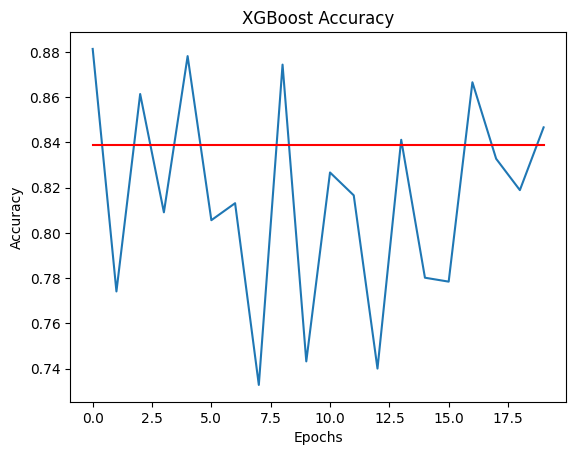

In [19]:
original_accuracy_list = [accuracy] * 20

plt.plot(range(20), clf_cat_xgboost_scores)
plt.plot(range(20), original_accuracy_list, color='red')

plt.title('XGBoost Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [20]:
#approach 2
#pick up random hyper parameter values and run 15 times to get a baseline. Repeat 10 times to plot average performance of XG Boost
#list of total possible combinations: 445,356,000
hyperparameter_dict = {
    'learning_rate': np.arange(0.1,1.0,0.1),
    'max_depth': range(3, 11),
    'subsample': np.arange(0.5, 1.01, 0.1),
    'colsample_bytree': np.arange(0.5, 1.01, 0.1),
    'min_child_weight': range(1, 11),
    'n_estimators': [100, 200, 300, 400, 500],
    'gamma': range(6),
    'reg_alpha': np.arange(0, 5.1, 0.1),
    'reg_lambda': np.arange(0, 5.1, 0.1)
}

In [21]:
#use randomised search CV to iterate 15 times
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    use_label_encoder=False,      # Disable internal label encoding
    eval_metric='logloss'         # Use log loss as the evaluation metric
)

#using 15 for now
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=hyperparameter_dict,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
                                        'reg_lambda': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='accuracy', verbose=1)

In [27]:
#move random search models into a df
df_random_search_results = pd.DataFrame(random_search.cv_results_)
df_random_search_results.head()

#get the best results
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

#get the worst results
worst_index = df_random_search_results['mean_test_score'].idxmin()
worst_params = df_random_search_results.loc[worst_index, 'params']

worst_score = df_random_search_results.loc[worst_index, 'mean_test_score']

worst_model = xgb.XGBClassifier(**worst_params)
worst_model.fit(X_train, y_train)

y_pred_worst = worst_model.predict(X_test)
accuracy_worst = accuracy_score(y_test, y_pred_worst)

print('accuracy_best: ', str(accuracy_best))
print('accuracy_worst: ', str(accuracy_worst))

accuracy_best:  0.878727880212845
accuracy_worst:  0.8458111619849028


In [28]:
print('best_params: ', random_search.best_params_)
print('worst_params: ', worst_params)

best_params:  {'subsample': 0.7, 'reg_lambda': 4.1000000000000005, 'reg_alpha': 0.2, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.5, 'gamma': 1, 'colsample_bytree': 0.6}
worst_params:  {'subsample': 0.8999999999999999, 'reg_lambda': 3.9000000000000004, 'reg_alpha': 1.4000000000000001, 'n_estimators': 400, 'min_child_weight': 8, 'max_depth': 5, 'learning_rate': 0.9, 'gamma': 5, 'colsample_bytree': 0.6}


best hyper params:


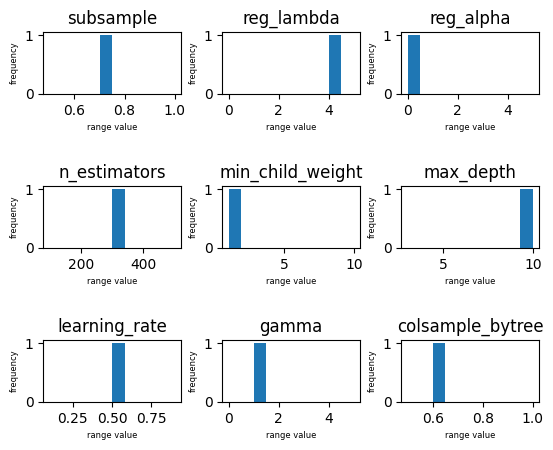

worst hyper params:


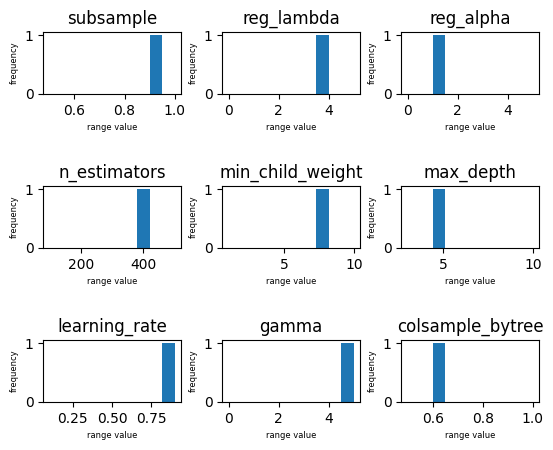

In [36]:
#plot params
def plot_hyper_params(params):
    params_len = len(params)
    col = 3
    row = int(params_len/3) + 0 if params_len%3 == 0 else 1

    fig, axes = plt.subplots(nrows=row, ncols=col, gridspec_kw={'hspace': 1.5, 'wspace': 0.3})
    
    i = 0
    j = 0
    
    for k,v in params.items():
        existing_range= (min(hyperparameter_dict[k]), max(hyperparameter_dict[k]))
        axes[i, j].hist([v], range=existing_range)

        axes[i, j].set_xlabel('range value', fontsize=6)
        axes[i, j].set_ylabel('frequency', fontsize=6)

        axes[i, j].set_title(k)

        j = j + 1
        if(j >= col):
            j = 0
            i = i + 1
    
    plt.show()



print('best hyper params:')
plot_hyper_params(random_search.best_params_)

print('worst hyper params:')
plot_hyper_params(worst_params)

========running iteration 0========
Fitting 3 folds for each of 15 candidates, totalling 45 fits
params results
accuracy_best:  0.878727880212845
best hyper params:


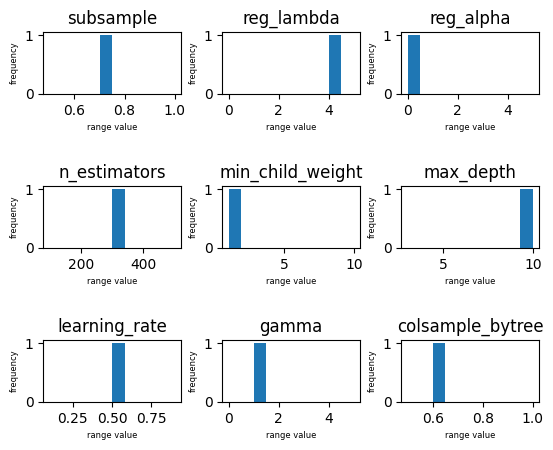

accuracy_worst:  0.8458111619849028
worst hyper params:


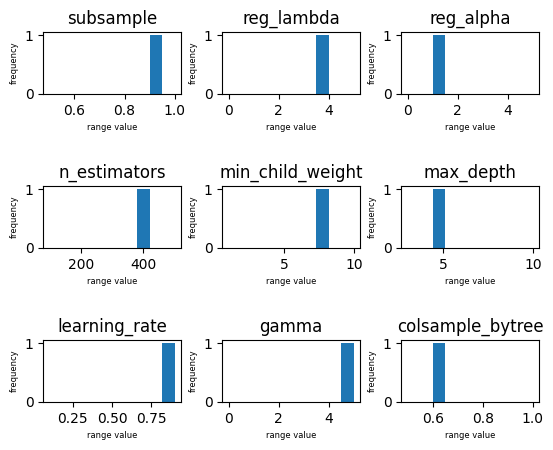

========running iteration 1========
Fitting 3 folds for each of 15 candidates, totalling 45 fits
params results
accuracy_best:  0.878727880212845
best hyper params:


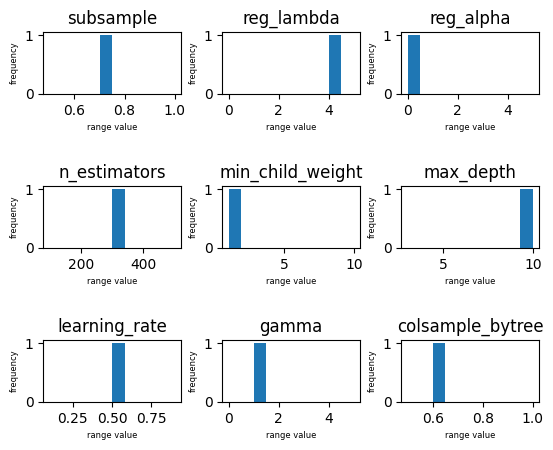

accuracy_worst:  0.8458111619849028
worst hyper params:


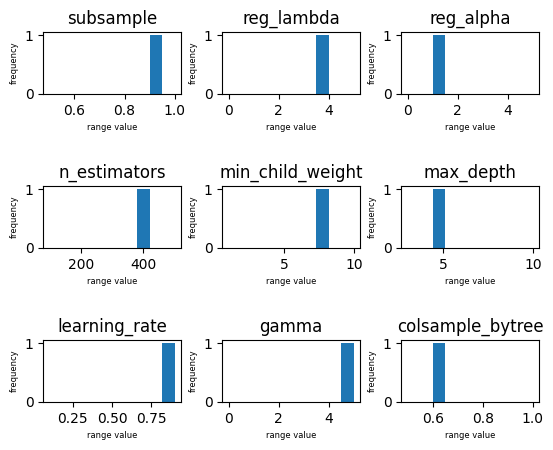

========running iteration 2========
Fitting 3 folds for each of 15 candidates, totalling 45 fits
params results
accuracy_best:  0.878727880212845
best hyper params:


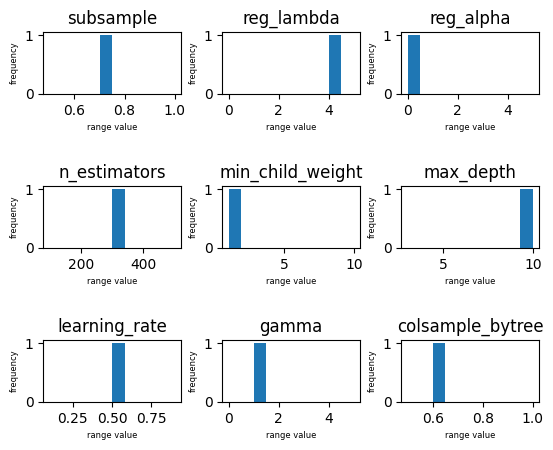

accuracy_worst:  0.8458111619849028
worst hyper params:


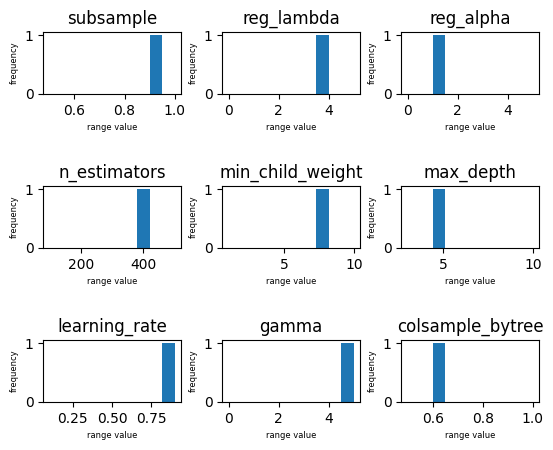

========running iteration 3========
Fitting 3 folds for each of 15 candidates, totalling 45 fits
params results
accuracy_best:  0.878727880212845
best hyper params:


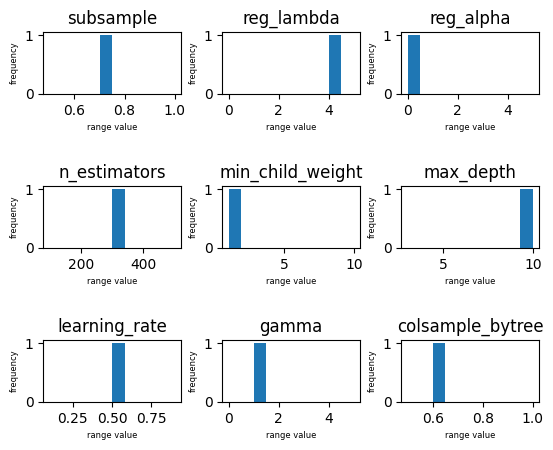

accuracy_worst:  0.8458111619849028
worst hyper params:


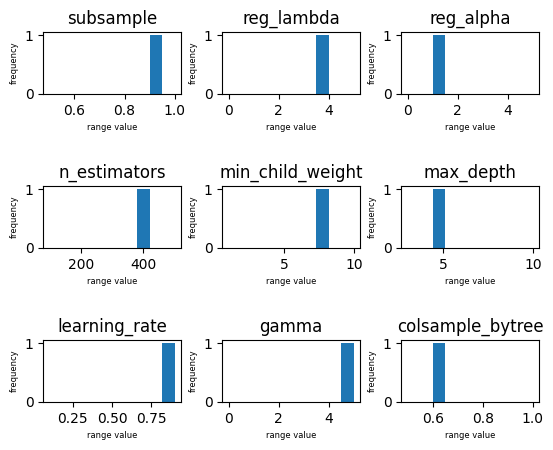

========running iteration 4========
Fitting 3 folds for each of 15 candidates, totalling 45 fits
params results
accuracy_best:  0.878727880212845
best hyper params:


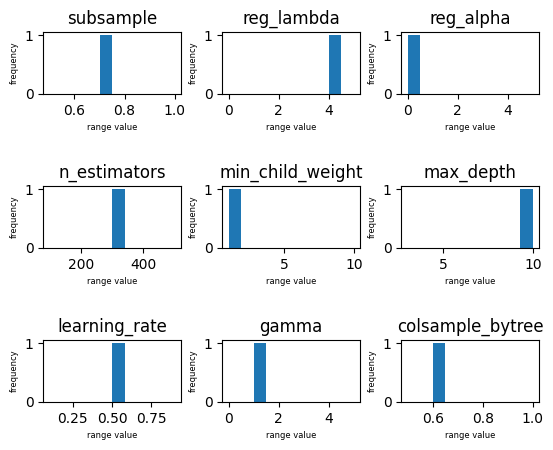

accuracy_worst:  0.8458111619849028
worst hyper params:


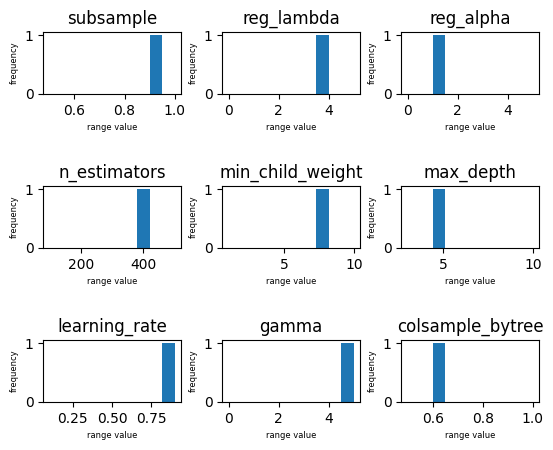

========running iteration 5========
Fitting 3 folds for each of 15 candidates, totalling 45 fits
params results
accuracy_best:  0.878727880212845
best hyper params:


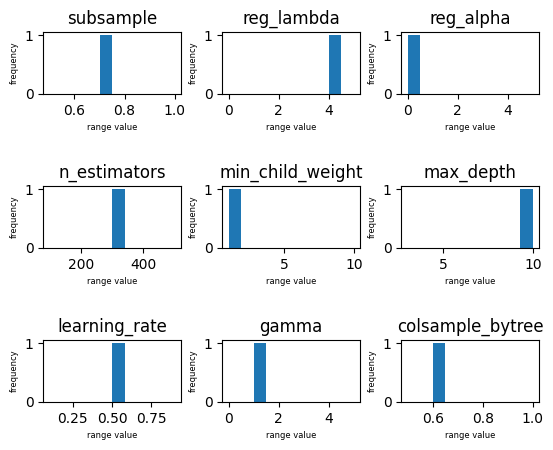

accuracy_worst:  0.8458111619849028
worst hyper params:


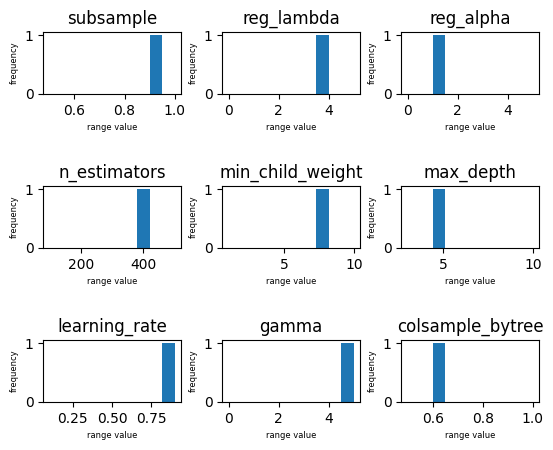

========running iteration 6========
Fitting 3 folds for each of 15 candidates, totalling 45 fits
params results
accuracy_best:  0.878727880212845
best hyper params:


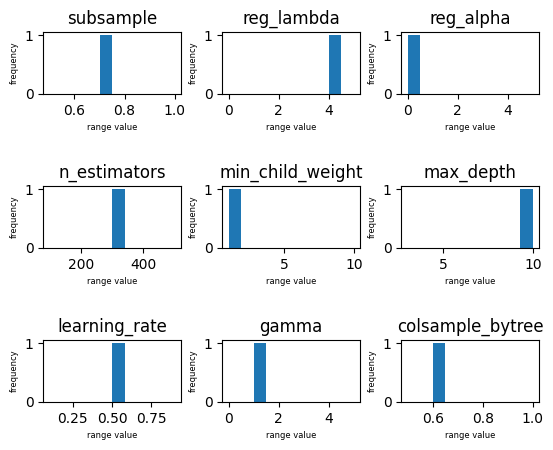

accuracy_worst:  0.8458111619849028
worst hyper params:


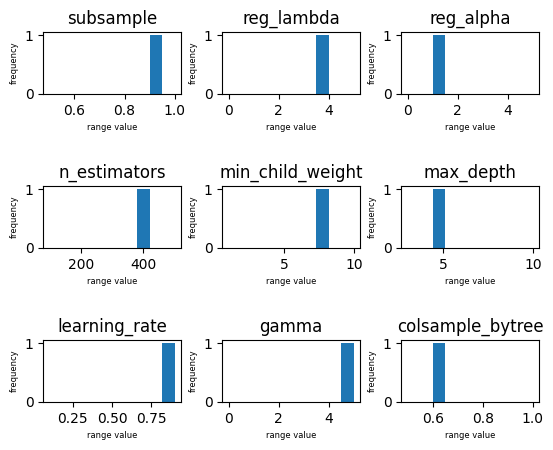

========running iteration 7========
Fitting 3 folds for each of 15 candidates, totalling 45 fits
params results
accuracy_best:  0.878727880212845
best hyper params:


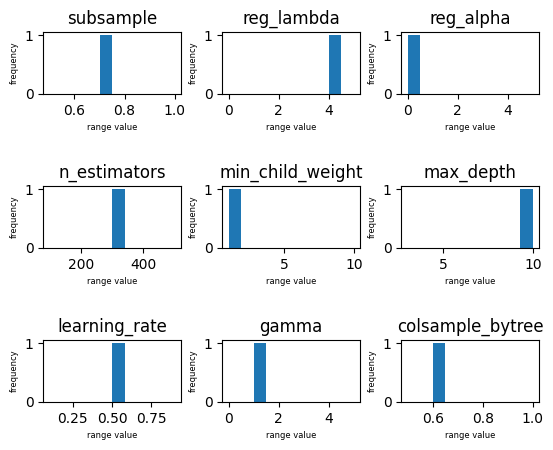

accuracy_worst:  0.8458111619849028
worst hyper params:


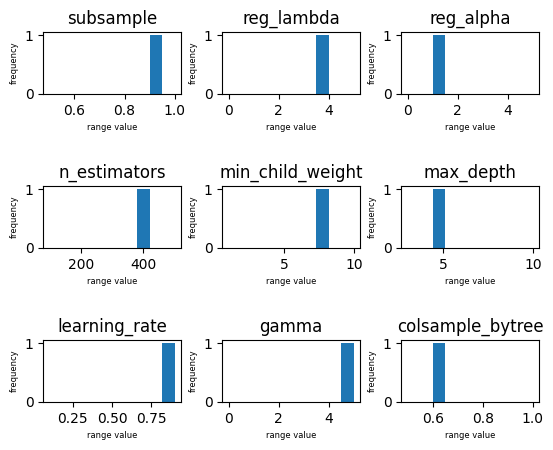

========running iteration 8========
Fitting 3 folds for each of 15 candidates, totalling 45 fits
params results
accuracy_best:  0.878727880212845
best hyper params:


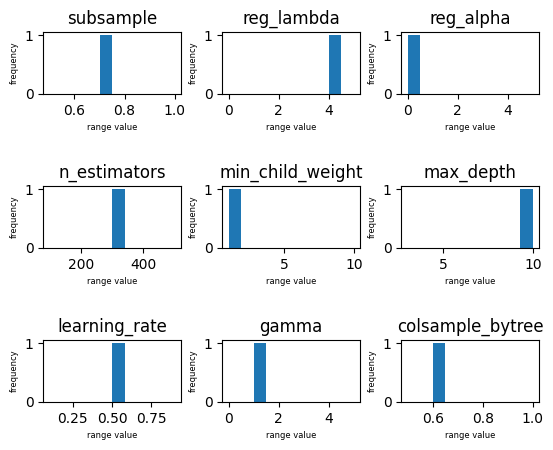

accuracy_worst:  0.8458111619849028
worst hyper params:


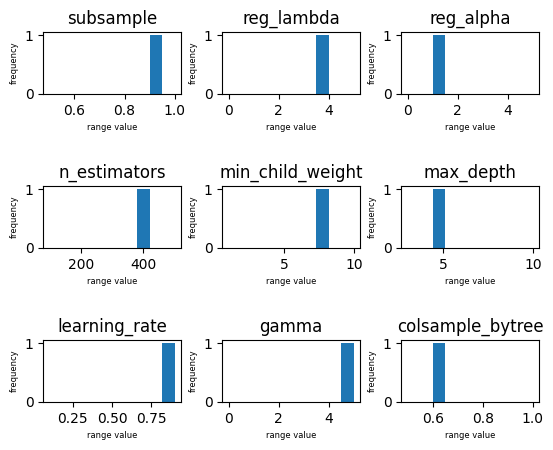

========running iteration 9========
Fitting 3 folds for each of 15 candidates, totalling 45 fits
params results
accuracy_best:  0.878727880212845
best hyper params:


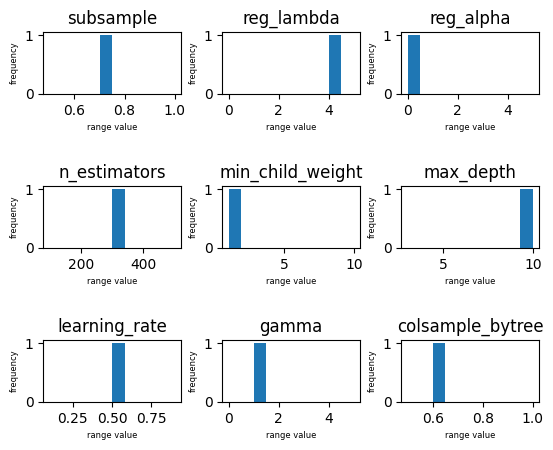

accuracy_worst:  0.8458111619849028
worst hyper params:


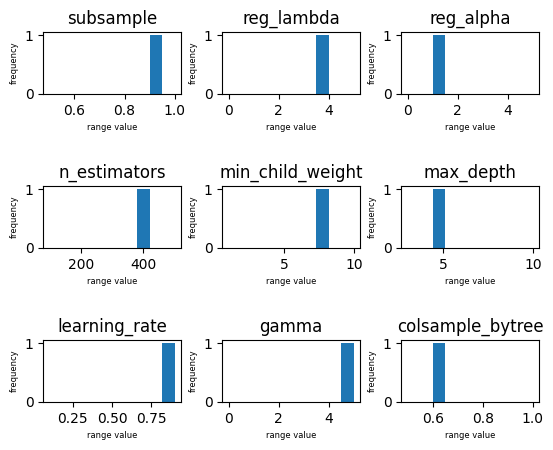

In [38]:
#repeat experiment 10 times
results_accuracy_obj_arr = []

for i in range(10):
    print('========running iteration {i}========'.format(i = i))
    random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=hyperparameter_dict,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1)

    random_search.fit(X_train, y_train)

    df_random_search_results = pd.DataFrame(random_search.cv_results_)
    df_random_search_results.head()

    #get the best results
    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train)

    y_pred_best = best_model.predict(X_test)
    accuracy_best = accuracy_score(y_test, y_pred_best)

    #get the worst results
    worst_index = df_random_search_results['mean_test_score'].idxmin()
    worst_params = df_random_search_results.loc[worst_index, 'params']

    worst_score = df_random_search_results.loc[worst_index, 'mean_test_score']

    worst_model = xgb.XGBClassifier(**worst_params)
    worst_model.fit(X_train, y_train)

    y_pred_worst = worst_model.predict(X_test)
    accuracy_worst = accuracy_score(y_test, y_pred_worst)

    results_obj = {
        'best': {
            'params': random_search.best_params_,
            'accuracy': accuracy_best
        },
        'worst': {
            'params': worst_params,
            'accuracy': accuracy_worst
        }

    }
    results_accuracy_obj_arr.append(results_obj)

    #plot
    print('params results')

    print('accuracy_best: ', str(accuracy_best))
    
    print('best hyper params:')
    plot_hyper_params(random_search.best_params_)

    print('accuracy_worst: ', str(accuracy_worst))
    print('worst hyper params:')
    plot_hyper_params(worst_params)


    

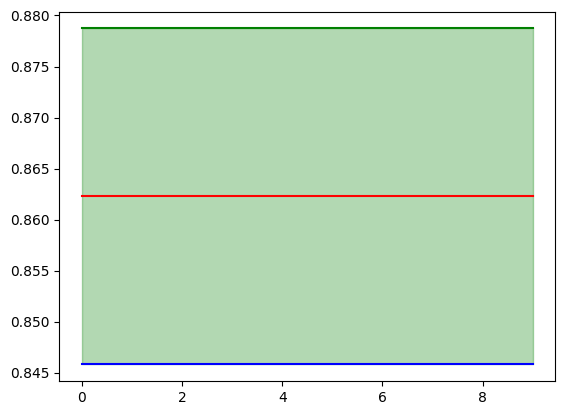

In [41]:
best_accuracy_arr = []
worst_accuracy_arr = []
avg_accuracy_arr = []

for results_obj in results_accuracy_obj_arr:
    best_accuracy = results_obj['best']['accuracy']
    worst_accuracy = results_obj['worst']['accuracy']
    avg_accuracy = (best_accuracy + worst_accuracy)/2
    
    best_accuracy_arr.append(best_accuracy)
    worst_accuracy_arr.append(worst_accuracy)
    avg_accuracy_arr.append(avg_accuracy)

# Plot the lines
plt.plot(range(10), best_accuracy_arr, label='best_accuracy', color='green')
plt.plot(range(10), worst_accuracy_arr, label='worst_accuracy', color='blue')
plt.plot(range(10), avg_accuracy_arr, label='average_accuracy', color='red')
plt.fill_between(range(10), best_accuracy_arr, worst_accuracy_arr, color='green', alpha=0.3)


In [42]:
print(best_accuracy_arr)
print(worst_accuracy_arr)
print(avg_accuracy_arr)

[0.878727880212845, 0.878727880212845, 0.878727880212845, 0.878727880212845, 0.878727880212845, 0.878727880212845, 0.878727880212845, 0.878727880212845, 0.878727880212845, 0.878727880212845]
[0.8458111619849028, 0.8458111619849028, 0.8458111619849028, 0.8458111619849028, 0.8458111619849028, 0.8458111619849028, 0.8458111619849028, 0.8458111619849028, 0.8458111619849028, 0.8458111619849028]
[0.8622695210988739, 0.8622695210988739, 0.8622695210988739, 0.8622695210988739, 0.8622695210988739, 0.8622695210988739, 0.8622695210988739, 0.8622695210988739, 0.8622695210988739, 0.8622695210988739]


In [ ]:
#attempt 4 use hyperopt to get some variance in the above example result
from hyperopt import hp, tpe, fmin, Trials
